In [1]:
import numpy as np
import gpflow
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import os

from gpflow.utilities import set_trainable, print_summary
gpflow.config.set_default_summary_fmt("notebook")

sys.path.append(os.path.split(os.path.split(os.getcwd())[0])[0]) # Move 2 levels up directory to import PBO
import PBO

In [2]:
def plot_gp(model, X, y, title="GP"):
    #Plotting code from GPflow authors

    ## generate test points for prediction
    xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)  # test points must be of shape (N, D)

    ## predict mean and variance of latent GP at test points
    mean, var = model.predict_f(xx)

    ## generate 10 samples from posterior
    samples = model.predict_f_samples(xx, 10)  # shape (10, 100, 1)

    ## plot 
    plt.figure(figsize=(12, 6))
    plt.plot(X, y, 'kx', mew=2)
    plt.plot(xx, mean, 'C0', lw=2)
    plt.fill_between(xx[:,0],
                     mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                     mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                     color='C0', alpha=0.2)

    plt.plot(xx, samples[:, :, 0].numpy().T, 'C0', linewidth=.5)
    plt.xlim(-0.1, 1.1)
    plt.title(title)

In [3]:
def forrester(x):
    """
    1-dimensional test function by Forrester et al. (2008)
    Defined as f(x) = (6x-2)^2 * sin(12x-4)
    :param x: float in domain [0, 1]
    """
    return (6*x-2)*(6*x-2)*np.sin(12*x-4)

In [4]:
X = np.expand_dims(np.linspace(start=0.0, stop=1.0, num=10), axis=1)
y = -forrester(X)

In [5]:
X

array([[0.        ],
       [0.11111111],
       [0.22222222],
       [0.33333333],
       [0.44444444],
       [0.55555556],
       [0.66666667],
       [0.77777778],
       [0.88888889],
       [1.        ]])

In [6]:
y

array([[ -3.02720998],
       [  0.81292911],
       [  0.4319724 ],
       [ -0.        ],
       [ -0.4319724 ],
       [ -0.81292911],
       [  3.02720998],
       [  5.78367567],
       [ -4.1572359 ],
       [-15.82973195]])

In [7]:
count = 10
n = X.shape[0]
d = X.shape[1]
D = 100

In [8]:
kernel = gpflow.kernels.RBF()
kernel.lengthscale.assign(0.1)

In [9]:
model = gpflow.models.VGP(data=(X,y),
                         kernel=kernel,
                         likelihood=gpflow.likelihoods.Gaussian())


In [10]:
print_summary(model)

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
VGP.kernel.lengthscale,Parameter,Softplus,,True,(),float64,0.1000000014901161
VGP.likelihood.variance,Parameter,Softplus + AffineScalar,,True,(),float64,1.0
VGP.q_mu,Parameter,,,True,"(10, 1)",float64,[[0....
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 10, 10)",float64,"[[[1., 0., 0...."


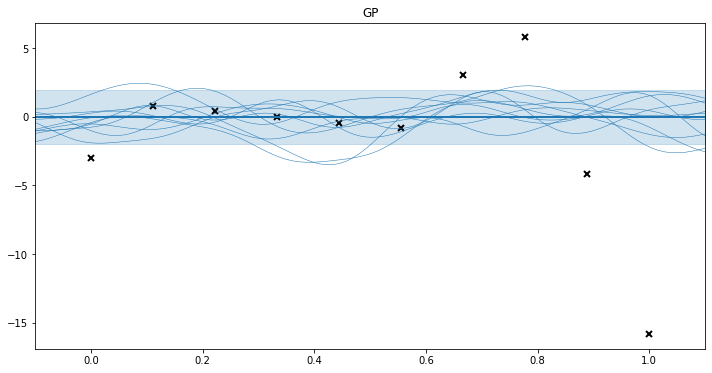

In [11]:
plot_gp(model, X, y)

In [12]:
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(lambda: -model.log_likelihood(), model.trainable_variables)

      fun: 27.036982971714906
 hess_inv: <68x68 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 9.49871318e-01, -1.57007901e-02,  1.80378884e-04, -2.22718273e-01,
       -2.74786636e-01, -2.28794054e-01, -2.24722812e-01, -2.70908224e-01,
       -2.08899908e-01, -5.27577167e-02,  1.40590689e-01,  1.28674649e-01,
        3.84578281e-02,  1.07649569e-01, -1.01764817e-01,  4.36725113e-04,
        7.14042766e-02,  6.24988085e-02, -8.87184959e-02, -5.92970205e-02,
        3.79120040e-02,  1.28528292e-02,  1.68997092e-02,  4.92844055e-01,
       -1.77425488e-01,  8.00354366e-02,  7.35319896e-02,  1.25859196e-01,
       -6.19174725e-02, -1.70905507e-01,  9.94697358e-04,  1.27054622e-01,
       -6.29095684e-02,  7.83363037e-02, -2.47396609e-02, -2.46896311e-02,
        5.73545665e-02,  1.70647478e-01, -6.31599776e-03, -1.05926139e-01,
       -7.96501093e-03,  1.56734978e-01, -2.02283785e-01, -1.64095279e-03,
        4.42291406e-02,  9.11539767e-02,  1.06024415e-01, -9.64400474e-02,
 

In [13]:
print_summary(model)

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,54.09412963774126
VGP.kernel.lengthscale,Parameter,Softplus,,True,(),float64,0.15709405698241347
VGP.likelihood.variance,Parameter,Softplus + AffineScalar,,True,(),float64,7.759776814576974e-05
VGP.q_mu,Parameter,,,True,"(10, 1)",float64,[[-0.41158754...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 10, 10)",float64,"[[[0.001198, 0., 0...."


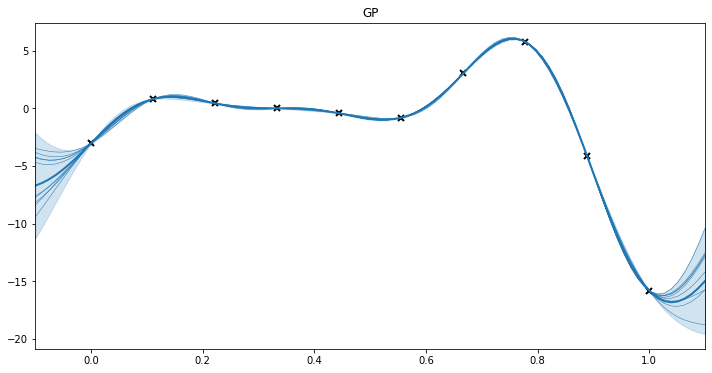

In [14]:
plot_gp(model, X, y)

In [15]:
kernel.K(X)

<tf.Tensor: id=832683, shape=(10, 10), dtype=float64, numpy=
array([[5.40941296e+01, 4.21230817e+01, 1.98897870e+01, 5.69482160e+00,
        9.88712701e-01, 1.04087865e-01, 6.64461899e-03, 2.57205389e-04,
        6.03712322e-06, 8.59250937e-08],
       [4.21230817e+01, 5.40941296e+01, 4.21230817e+01, 1.98897870e+01,
        5.69482160e+00, 9.88712701e-01, 1.04087865e-01, 6.64461899e-03,
        2.57205389e-04, 6.03712322e-06],
       [1.98897870e+01, 4.21230817e+01, 5.40941296e+01, 4.21230817e+01,
        1.98897870e+01, 5.69482160e+00, 9.88712701e-01, 1.04087865e-01,
        6.64461899e-03, 2.57205389e-04],
       [5.69482160e+00, 1.98897870e+01, 4.21230817e+01, 5.40941296e+01,
        4.21230817e+01, 1.98897870e+01, 5.69482160e+00, 9.88712701e-01,
        1.04087865e-01, 6.64461899e-03],
       [9.88712701e-01, 5.69482160e+00, 1.98897870e+01, 4.21230817e+01,
        5.40941296e+01, 4.21230817e+01, 1.98897870e+01, 5.69482160e+00,
        9.88712701e-01, 1.04087865e-01],
       [1.0408

In [16]:
phi, W, b = PBO.acquisitions.pes.fourier_features(np.expand_dims(X, axis=0), kernel)
mat = phi @ tf.linalg.matrix_transpose(phi)
for i in range(999):
    phi, W, b = PBO.acquisitions.pes.fourier_features(np.expand_dims(X, axis=0), kernel)
    mat += phi @ tf.linalg.matrix_transpose(phi)
mat/1000

<tf.Tensor: id=871684, shape=(1, 10, 10), dtype=float64, numpy=
array([[[54.26478604, 52.19642456, 46.4310237 , 38.18923793,
         29.03322383, 20.38970205, 13.21200391,  7.87838321,
          4.29727263,  2.11228593],
        [52.19642456, 54.25356195, 52.15367456, 46.36670463,
         38.12217072, 28.98290428, 20.36512094, 13.20513833,
          7.86739636,  4.2584208 ],
        [46.4310237 , 52.15367456, 54.18924288, 52.08660735,
         46.31638508, 38.09758961, 28.9760387 , 20.35413409,
         13.1662865 ,  7.78935699],
        [38.18923793, 46.36670463, 52.08660735, 54.13892333,
         52.06202624, 46.30951951, 38.08660276, 28.93718686,
         20.27609472, 13.05866181],
        [29.03322383, 38.12217072, 46.31638508, 52.06202624,
         54.13205776, 52.05103939, 46.27066767, 38.00856339,
         28.82956218, 20.16618796],
        [20.38970205, 28.98290428, 38.09758961, 46.30951951,
         52.05103939, 54.09320592, 51.97300002, 46.16304299,
         37.89865663, 28

In [17]:
samples = PBO.acquisitions.pes.sample_maximizers(X=X,
                                      y=y,
                                      count=50,
                                      D=100,
                                      model=model)
samples

Loss at step 0: -42.13286836618551
Loss at step 200: -83.03334300307725
Loss at step 400: -120.93600643322588
Loss at step 600: -147.6124852202878
Loss at step 800: -161.70420430442465
Loss at step 1000: -167.82932539051473
Loss at step 1200: -170.23851797689102
Loss at step 1400: -171.1486574874018
Loss at step 1600: -171.48198273414968
Loss at step 1800: -171.5970254956419
Loss at step 2000: -171.63302953438114
Loss at step 2200: -171.64291347495174
Loss at step 2400: -171.64523135045414
Loss at step 2600: -171.6456850949074
Loss at step 2800: -171.64575759253654


<tf.Tensor: id=1277222, shape=(50, 1), dtype=float64, numpy=
array([[0.73191958],
       [0.73200452],
       [0.74490891],
       [0.73419559],
       [0.17884118],
       [0.73225948],
       [0.73575491],
       [0.20907176],
       [0.20832576],
       [0.73555968],
       [0.72970336],
       [0.73428683],
       [0.73995188],
       [0.21712329],
       [0.15023394],
       [0.7309648 ],
       [0.73077474],
       [0.20713015],
       [0.73571464],
       [0.18801555],
       [0.73447887],
       [0.73219431],
       [0.73295192],
       [0.18472934],
       [0.17162488],
       [0.17695996],
       [0.73049666],
       [0.7310121 ],
       [0.73934811],
       [0.73396919],
       [0.17696142],
       [0.73203704],
       [0.20004496],
       [0.73032475],
       [0.73615488],
       [0.7321237 ],
       [0.73602505],
       [0.20207799],
       [0.72759197],
       [0.73086698],
       [0.7405883 ],
       [0.73739444],
       [0.20415597],
       [0.72976724],
       [0.73425

In [2]:
#Setup simple dataset
#Rule: Prefer values closer to 0.7

x_0 = np.array([0.1, 0.2])
y_0 = np.array([0])
x_1 = np.array([0.2, 0.4])
y_1 = np.array([0])
x_2 = np.array([0.7, 0.5])
y_2 = np.array([1])
x_3 = np.array([0.9, 1.0])
y_3 = np.array([1])
x_4 = np.array([0.6, 0.4])
y_4 = np.array([1])
x_5 = np.array([0.1, 0.3])
y_5 = np.array([0])
x_6 = np.array([0.2, 0.5])
y_6 = np.array([0])
x_7 = np.array([0.7, 0.3])
y_7 = np.array([1])
x_8 = np.array([0.8, 1.0])
y_8 = np.array([1])
x_9 = np.array([0.7, 0.9])
y_9 = np.array([1])
x_10 = np.array([0.2, 0.1])
y_10 = np.array([1])
x_11 = np.array([0.4, 0.2])
y_11 = np.array([1])
x_12 = np.array([0.5, 0.7])
y_12 = np.array([0])
x_13 = np.array([1.0, 0.9])
y_13 = np.array([0])
x_14 = np.array([0.4, 0.6])
y_14 = np.array([0])
x_15 = np.array([0.3, 0.1])
y_15 = np.array([1])
x_16 = np.array([0.5, 0.2])
y_16 = np.array([1])
x_17 = np.array([0.3, 0.7])
y_17 = np.array([0])
x_18 = np.array([1.0, 0.8])
y_18 = np.array([0])
x_19 = np.array([0.9, 0.7])
y_19 = np.array([0])
x_20 = np.array([0.95, 0.6])
y_20 = np.array([0])
x_21 = np.array([0.15, 0.25])
y_21 = np.array([0])
x_22 = np.array([0.25, 0.45])
y_22 = np.array([0])
x_23 = np.array([0.75, 0.55])
y_23 = np.array([1])
x_24 = np.array([0.95, 0.9])
y_24 = np.array([0])
x_25 = np.array([0.65, 0.45])
y_25 = np.array([1])
x_26 = np.array([0.15, 0.35])
y_26 = np.array([0])
x_27 = np.array([0.25, 0.55])
y_27 = np.array([0])
x_28 = np.array([0.75, 0.35])
y_28 = np.array([1])
x_29 = np.array([0.85, 0.95])
y_29 = np.array([1])
x_30 = np.array([0.75, 0.95])
y_30 = np.array([1])
x_31 = np.array([0.25, 0.15])
y_31 = np.array([1])
x_32 = np.array([0.45, 0.25])
y_32 = np.array([1])
x_33 = np.array([0.55, 0.75])
y_33 = np.array([0])
x_34 = np.array([0.95, 0.9])
y_34 = np.array([0])
x_35 = np.array([0.7, 0.09])
y_35 = np.array([1])
x_36 = np.array([0.7, 0.1])
y_36 = np.array([1])
x_37 = np.array([0.7, 0.1])
y_37 = np.array([1])
x_38 = np.array([0.7, 0.1])
y_38 = np.array([1])
x_39 = np.array([0.67, 0.1])
y_39 = np.array([1])
x_40 = np.array([0.71, 0.1])
y_40 = np.array([1])
x_41 = np.array([0.7, 0.1])
y_41 = np.array([1])

Xtrain = np.stack([x_0, x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9, 
                   x_10, x_11, x_12, x_13, x_14, x_15, x_16, x_17, x_18, x_19, 
                   x_20, x_21, x_22, x_23, x_24, x_25, x_26, x_27, x_28, x_29, 
                   x_30, x_31, x_32, x_33, x_34, x_35, x_36, x_37, x_38, x_39, 
                   x_40, x_41])
Ytrain = np.stack([y_0, y_1, y_2, y_3, y_4, y_5, y_6, y_7, y_8, y_9, 
                   y_10, y_11, y_12, y_13, y_14, y_15, y_16, y_17, y_18, y_19, 
                   y_20, y_21, y_22, y_23, y_24, y_25, y_26, y_27, y_28, y_29, 
                   y_30, y_31, y_32, y_33, y_34, y_35, y_36, y_37, y_38, y_39, 
                   y_40, y_41])

In [3]:
def log(message):
    print(str(datetime.datetime.now()) + ': ' + message)

In [4]:
class RFFApproximationKernel(Stationary):
    """
    Approximates the radial basis function kernel using rff_z function
    
    :param D: Number of random Fourier features to use
    """
    def rff_z(self, X, W):
        """
        From RandomFourierFeatures by Tetsuya Ishikawa
        If W is generated from standard normal distribution, outputs z(x) where z(x)'z(y) approximates rbf_k(x, y)

        :param X: a matrix of size n x d
        :param W: a matrix of size d x D

        """
        D = tf.dtypes.cast(W.shape[1], dtype=tf.float64)
        ts = tf.tensordot(X, W, axes=1)
        cs = tf.cos(ts)
        ss = tf.sin(ts)
        return tf.sqrt(1/D)*tf.concat([cs, ss], axis=1)
    
    def __init__(self, input_dim, D=100, variance=1.0, lengthscales=1.0,
                 active_dims=None, ARD=None, name=None):
        super().__init__(input_dim)
        self.W = np.random.randn(input_dim, D)
        
    @params_as_tensors
    def K(self, X, X2=None):
        z_X = self.rff_z(X, self.W)
        if X2 is None:
            return self.variance*tf.tensordot(z_X, tf.transpose(z_X), axes=1)
        else:
            z_X2 = self.rff_z(X2, self.W)
            return self.variance*tf.tensordot(z_X, tf.transpose(z_X2), axes=1)
        
    @params_as_tensors
    def Kdiag(self, X, presliced=False):
        return tf.fill(tf.shape(X)[:-1], tf.squeeze(self.variance))

In [58]:
m = gpflow.models.VGP(Xtrain, Ytrain,
                      kern=gpflow.kernels.RBF(input_dim=2),
                      likelihood=gpflow.likelihoods.Bernoulli())
r = gpflow.train.ScipyOptimizer().minimize(m, maxiter=2000)
models = []
models.append(m)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 12.490350
  Number of iterations: 132
  Number of functions evaluations: 142


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 12.490350
  Number of iterations: 132
  Number of functions evaluations: 142


In [81]:
m.objective.eval(session=gpflow.get_default_session())

12.490350358497544

In [49]:
m2 = gpflow.models.VGP(Xtrain, Ytrain,
                      kern=RFFApproximationKernel(input_dim=2),
                      likelihood=gpflow.likelihoods.Bernoulli())
gpflow.train.ScipyOptimizer().minimize(m2, maxiter=5000)

NameError: name 'RFFApproximationKernel' is not defined

In [ ]:
def combinations(points):
    n = points.shape[0]
    d = points.shape[1]

    out = np.zeros((n*n, d*2))
    for i in range(n):
        for j in range(n):
            out[i*n+j][0:d] = points[i]
            out[i*n+j][d:d*2] = points[j]
    return out

X1 = np.matrix([[0.1],
                [0.2],
                [0.3],
                [0.4],
                [0.5],
                [0.6],
                [0.7],
                [0.8],
                [0.9],
                [1.0]])
Xcombs = combinations(X1)
m_pred = m.predict_y(Xcombs)
m2_pred = m2.predict_y(Xcombs)

X = np.matrix([[0.1, 0.1],
               [0.2, 0.2],
               [0.3, 0.3],
               [0.7, 0.7]])
X2 = np.matrix([[0.2, 0.2],
                [0.3, 0.3]])

fake_kern = RFFApproximationKernel(input_dim=2)
rbf_kern = gpflow.kernels.RBF(input_dim=2)

print(fake_kern.compute_K_symm(X)-rbf_kern.compute_K_symm(X))
print(fake_kern.compute_K(X, X2)-rbf_kern.compute_K(X, X2))
print(fake_kern.compute_K(X2, X)-rbf_kern.compute_K(X2, X))
print(m2_pred[0] - m_pred[0])

In [ ]:
X1 = np.matrix([[0.1],
                [0.2],
                [0.3],
                [0.4],
                [0.5],
                [0.6],
                [0.7],
                [0.8],
                [0.9],
                [1.0]])
Xcombs = combinations(X1)
m_pred = m.predict_f(Xcombs)
m2_pred = m2.predict_y(Xcombs)


In [ ]:
def logistic(x):
    """
    :param x: Input of shape ?xD
    """
    return (1/(1+tf.math.exp(-x)))

In [ ]:
def logistic_square(x):
    """
    Integrand function for gpflow mvquad function
    :param x: Input of shape ?xD
    """
    return tf.math.square(logistic(x))

In [ ]:
def variance_integral(means, variances):
    return mvnquad(logistic_square, means, variances, H=100, Din=1)

In [ ]:
def expected_integral(means, variances):
    return mvnquad(logistic, means, variances, H=100, Din=1)

In [ ]:
def variance_logistic_f(m, x):
    log("Calculating variance of logistic f")
    means, variances = m.predict_f(x)
    variances = np.expand_dims(variances, axis=1)
    expected_logistic_squared = tf.math.square(expected_integral(means, variances))
    return (variance_integral(means, variances)-expected_logistic_squared).eval(session=tf.Session())

In [ ]:
X1 = np.matrix([[0.7, 0.1],
                [0.7, 0.2],
                [0.7, 0.3],
                [0.7, 0.4],
                [0.7, 0.5],
                [0.7, 0.6],
                [0.7, 0.7],
                [0.7, 0.8],
                [0.7, 0.9],
                [0.7, 1.0],
                [0.7, 1.1]])
variance_logistic_f(m, X1)

In [ ]:
means, variances = m.predict_f(X1)
means

In [ ]:
variances

In [ ]:
variance_integral(means, np.expand_dims(variances, axis=1)).eval(session=tf.Session())

In [ ]:
tf.square(logistic(means)).eval(session=tf.Session())

In [ ]:
def gridParams():
    mins = [-3.25,-2.85 ]
    maxs = [ 3.65, 3.4 ]
    nGrid = 50
    xspaced = np.linspace(mins[0], maxs[0], nGrid)
    yspaced = np.linspace(mins[1], maxs[1], nGrid)
    xx, yy = np.meshgrid(xspaced, yspaced)
    Xplot = np.vstack((xx.flatten(),yy.flatten())).T
    return mins, maxs, xx, yy, Xplot

def plot(m, ax):
    col1 = '#0172B2'
    col2 = '#CC6600'
    mins, maxs, xx, yy, Xplot = gridParams()
    p = m.predict_y(Xplot)[0]
    ax.plot(Xtrain[:,0][Ytrain[:,0]==1], Xtrain[:,1][Ytrain[:,0]==1], 'o', color=col1, mew=0, alpha=0.5)
    ax.plot(Xtrain[:,0][Ytrain[:,0]==0], Xtrain[:,1][Ytrain[:,0]==0], 'o', color=col2, mew=0, alpha=0.5)
    if hasattr(m, 'feat') and hasattr(m.feat, 'Z'):
        Z = m.feature.Z.read_value()
        ax.plot(Z[:,0], Z[:,1], 'ko', mew=0, ms=4)
        ax.set_title('m={}'.format(Z.shape[0]))
    else:
        ax.set_title('full')
    ax.contour(xx, yy, p.reshape(*xx.shape), [0.5], colors='k', linewidths=1.8, zorder=100)

mins, maxs, xx, yy, Xplot = gridParams()
Xplot.shape    
    
# make plots.
fig, axes = plt.subplots(1, len(models), figsize=(8, 8), sharex=True, sharey=True)
plot(m, axes)

In [ ]:
def soft_copeland(m, x):
    """"
    Average of the probability that x is the winner of a duel against all elements in x
    
    :param m: a gpflow model that predicts pi[x, x']
    :param x: a matrix of size n x d/2
    
    Returns a 1 x n matrix of means
    """   
    n = x.shape[0]
    d = x.shape[1]*2
    
    def combinations(points):
        n = points.shape[0]
        d = points.shape[1]

        out = np.zeros((n*n, d*2))
        for i in range(n):
            for j in range(n):
                out[i*n+j][0:d] = points[i]
                out[i*n+j][d:d*2] = points[j]
        return out

    combs = np.matrix(combinations(x))
    preds = m.predict_y(combs)
    means = np.zeros(n)
    for i in range(n):
        means[i] = np.mean(preds[0][i*n:(i+1)*n])
    return np.matrix(means)

In [ ]:
def sample_variances(m, x, x_other):
    x_tiled = np.tile(x, (x_other.shape[0], 1))
    x_xprime = np.bmat([x_tiled, x_other])
    return variance_logistic_f(m, x_xprime)

In [ ]:
def uniform_sample_func(input_dim, low=0.0, high=1.0):
    def func(num_points):
        return np.random.uniform(low, high, [num_points, input_dim])
    return func

def dueling_thompson_sampling(m, m_approx, sample_func, num_sample_points=500):
    """
    Dueling-Thompson sampling. Returns x and x' as the next input points to evaluate
    
    :param m: Trained model f
    :param m_approx: Sample model f
    :param sample_func: function that takes num_sample_points as a parameter
    :param num_sample_points: number of uniformly sampled points over input space to take the argmax over
    """
    
    #Step 1: selecting x    
    #Pick num_sample_points random points in input space using sample_func
    sample_points = sample_func(num_sample_points)
    means = soft_copeland(m_approx, sample_points)
    x_idx = np.argmax(means)
    x = sample_points[x_idx][0]
    log("Picked x with value " + str(x) + " and soft Copeland score " + str(means.item(x_idx)))
    
    # Remove x from sample_points so that we will not pick x' to be the same value
    sample_points[x_idx] = sample_points[0]
    
    #Step 2: selecting x'
    variances = sample_variances(m, x, sample_points).squeeze()
    var_idx = np.argmax(variances)
    x_prime = sample_points[var_idx][0]
    log("Picked x' with value " + str(x_prime) + " and variance " + str(variances.item(var_idx)))
    
    return np.matrix([x, x_prime])

In [ ]:
def forrester(x):
    """
    Simple one-dimensional test function by Forrester et al. (2008)
    Defined as f(x) = (6x-2)^2 * sin(12x-4)
    """
    return (6*x-2)*(6*x-2)*np.sin(12*x-4)

In [ ]:
def forrester_get_y(pairs):
    """
    :param pairs: n x 2 matrix of input pairs [x, x'], x and x' are floats in [0, 1]
    
    Returns n x 1 matrix of y values indicating 1 if x wins the duel and 0 if x' wins the duel
    """
    n = pairs.shape[0]
    
    out = np.zeros([n, 1])
    for i in range(n):
        out[i][0] = int(forrester(pairs.item((i, 0))) <= forrester(pairs.item(i, 1)))
    
    return np.matrix(out)

In [ ]:
def PBO(X, Y, n, acquisition_func, winner_func):
    """
    Preferential Bayesian optimization algorithm (Algorithm 1) described in Preferential Bayesian Optimization by
    Gonzalez et al. (2017), to find Condorcet's winner
    
    :param X: matrix of size N x d. Training input points
    :param Y: matrix of size N x 1. Training target classifications
    :param acquisition_func: Function that returns next duel pair
    :param winner_func: Function that determines the winners of duel pairs
    """
    d = X.shape[1]
    
    for j in range(n):
        log("Starting iteration " + str(j))
        print(X)
        print(Y)
        
        #1. Fit a GP with kernel k to Dj and learn pi(x).
                
        # Train real f
        log("Training GP f")
        kern_rbf = gpflow.kernels.RBF(input_dim=d)
        kern_rbf.lengthscales.trainable = False
        kern_rbf.lengthscales = 0.1
        m = gpflow.models.VGP(X, Y, 
                               kern=kern_rbf, 
                               likelihood=gpflow.likelihoods.Bernoulli())
        gpflow.train.ScipyOptimizer().minimize(m)
        
        # Sample f using RFF
        log("Training RFF approximation GP of f")
        kern_rff = RFFApproximationKernel(input_dim=d) #Have to instantiate every time to obtain a different sample of f
        kern_rff.lengthscales.trainable = False
        kern_rff.lengthscales = 0.1
        m_approx = gpflow.models.VGP(X, Y, 
                               kern=kern_rff, 
                               likelihood=gpflow.likelihoods.Bernoulli())
        gpflow.train.ScipyOptimizer().minimize(m_approx)

        # 2 and 3. Compute the acquisition for duels alpha and get next duel
        log("Computing acquisition function")
        x_xprime_next = acquisition_func(m, m_approx, uniform_sample_func(1))
        log("x and x_prime: " + str(x_xprime_next))
        
        # 4. Run the duel and get y
        y_next = winner_func(x_xprime_next)
        log("y_next: " + str(y_next))
        
        # 5. Augment X and Y
        X = np.vstack([X, x_xprime_next])
        Y = np.vstack([Y, y_next])
    
    #Fit a GP with kernel k to Dn
    log("Training final GP")
    kern_rbf = gpflow.kernels.RBF(input_dim=d)
    kern_rbf.lengthscales.trainable = False
    kern_rbf.lengthscales = 0.1
    m_final = gpflow.models.VGP(X, Y, 
                                 kern=kern_rbf, 
                                 likelihood=gpflow.likelihoods.Bernoulli())
    gpflow.train.ScipyOptimizer().minimize(m_final)
    
    #Return current Condorcet's winner x*
    sample_points = uniform_sample_func(1)(1000)
    x_final = sample_points[np.argmax(soft_copeland(m_final, sample_points))][0]
    return X, Y, m_final, x_final

In [ ]:
Xtest = np.matrix([[0.1, 0.4],
                   [0.5, 0.2],
                   [0.8, 0.9],
                   [0.24, 0.7],
                   [0.6, 0.52]])
Ytest = forrester_get_y(Xtest)
X, Y, m_final, result = PBO(Xtest, Ytest, 30, dueling_thompson_sampling, forrester_get_y)